# Mini-Projet : Segmentation d'images TEP par classification spectrale

L'objectif de ce TP est de segmenter des images de Tomographie par Emission de Positons (TEP)  via des méthodes de classification non supervisée et, en particulier, une méthode de classification spectrale. 

## Principe de l'imagerie TEP 

La Tomographie par Emission de Positons (ou TEP) est une technique d'imagerie médicale fonctionnelle quantitative permettant de visualiser les activités du métabolisme. Les données TEP forment une sèquence *3D + t* qui traduit l'évolution de la radioactivité dans le temps du volume correspondant au champ de vue de l'appareil de mesure.


<img src="files/PrincipePET.png" width="600" height="300">



Nous nous intéressons, dans ce TP, à la segmentation d'une coupe transverse et sagittale du cerveau, réprésentée respectivement à gauche et à droite sur la figure ci-dessous. Le nombre de classes à retrouver correspond aux différentes couleurs représentées sur la figure. Ici, l'information géométrique (position de chaque pixel dans l'image) n'est pas prise en compte.

<img src="files/zubal_fig3.png" width="600" height="300">


Ce mini-projet se décompose en 5 parties:
- **Partie I :** implémentation de la classification spectrale avec exemple jouet 
- **Partie II :** application de la classification spectrale sur les protils temporels TACs 
- **Partie III :** classification par Kmeans puis par réduction de dimension ACP+Kmeans
- **Partie IV :** évaluation des résultats
- **Partie V :** votre analyse



In [1]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

## Partie I : Classification spectrale

Parmi les méthodes de partitionnement non supervisé, les méthodes à noyaux reposent sur le même principe : elles utilisent des relations d'adjacence (d'affinité) entre tous les couples de points sans a priori sur les formes des classes. Nous nous concentrons sur l'algorithme de classification spectrale décrit ci-dessous, très simple à implémenter. La mesure d'affinité utilisée est l'affinité gaussienne qui dépend d'un paramètre noté $\sigma$.


On dispose d'un ensemble  de données $S=\{x_i\}_{i=1,..,n}\in \mathbb{R}^p$ composé de $n$ points de dimension $p$ et d'un nombre de classes, noté $k$, à obtenir. La méthode de classification spectrale  consiste à extraire les vecteurs propres associés aux plus grandes valeurs propres d'une matrice d'affinité normalisée. Ces vecteurs propres constituent ensuite un espace de dimension réduite dans lequel les données transformées seront linéairement séparables.  

<img src="files/AlgoSC.png" width="600" height="300">
<img src="files/SCexple.png" width="600" height="300">


### Travail demandé

- Ecrire la fonction **classification_spectrale** implantant l'algorithme 1. Cette fonction en entrée les données Input de l'algorithme.
- Tester la fonction sur le jeu de données *ToyExample.mat* et tester différentes valeurs de paramètres $\sigma$. Les résultats sont-ils similaires ?


### Fonctions python utiles
- exp (numpy)
- norm (linalg)
- inv (linalg)
- eig (linalg)
- KMeans (sklearn)

In [4]:

def classification_spectrale(Data,k,sigma,nbCluster):
    Data=np.asarray(Data)
    k=int(k)

    # construction de la matrice affinité
    A = np.exp(-(euclidean_distances(Data,Data)**2)/(2*(sigma**2)))
    np.fill_diagonal(A, 0)

    # Normalisation de la matrice affinité
    D = np.diag(np.sum(A, axis=1))
    
    # Calcul des vecteurs propres de L
    L = np.linalg.inv(D).dot(A)
    
    #Extraction des k + grands vecteurs propres
    valp, vecp = np.linalg.eig(L)
    # -valp car on prend les k plus grandes valeurs sinon k plus petites
    tmpVal = np.argsort(-valp)[:k]
    X = np.array([vecp[:,x] for x in tmpVal]).T  
      
    # Normalisation des lignes de XmatJouet
    Y = np.zeros(X.shape)
    for i in range(X.shape[0]):
      for j in range(Y.shape[1]):
        Y[i,j] = X[i,j]/(np.sum(X[i]**2)**(1/2))
    
    #Kmeans sur l'espace spectral
    kmeans = KMeans(n_clusters=nbCluster, random_state=0).fit(Y)
    cluster = kmeans.labels_
      
    return cluster

### Application : toy example

[[ 4.39451508e+00  1.00000000e+00]
 [ 4.57536719e+00  1.16545279e+00]
 [ 4.43341117e+00  1.31102121e+00]
 [ 3.98965866e+00  1.39684527e+00]
 [ 4.39326063e+00  1.58290024e+00]
 [ 4.40546839e+00  1.79630530e+00]
 [ 4.14638470e+00  1.96666971e+00]
 [ 4.06570762e+00  2.12035135e+00]
 [ 4.18239199e+00  2.20613699e+00]
 [ 4.22321428e+00  2.54925516e+00]
 [ 3.90573279e+00  2.45519129e+00]
 [ 3.95109660e+00  2.68510742e+00]
 [ 3.73449153e+00  2.76797879e+00]
 [ 3.64927649e+00  2.64815048e+00]
 [ 3.66110463e+00  3.12588518e+00]
 [ 3.78469008e+00  3.02712902e+00]
 [ 3.50321742e+00  3.58599046e+00]
 [ 3.45029770e+00  3.14350540e+00]
 [ 3.33148699e+00  3.27319433e+00]
 [ 3.23161155e+00  3.77067466e+00]
 [ 3.16986466e+00  3.80513680e+00]
 [ 3.06263186e+00  3.93540238e+00]
 [ 2.95273272e+00  3.88677302e+00]
 [ 2.55777932e+00  3.92566768e+00]
 [ 2.63861511e+00  3.89660135e+00]
 [ 2.54391630e+00  3.98378327e+00]
 [ 2.26035298e+00  3.79054485e+00]
 [ 2.07557851e+00  4.20053618e+00]
 [ 1.74149697e+00  4

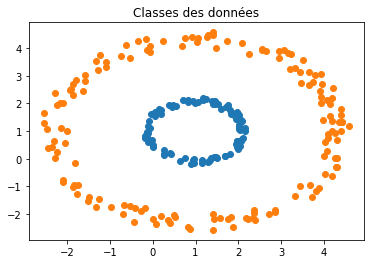

In [5]:

matJouet = scipy.io.loadmat("ToyExample.mat")

ExpleJouet = pd.DataFrame(matJouet['Data'])
ExpleJouet=np.asarray(ExpleJouet)

# Classification du jeu de données
sigma = 0.1
k = 2
nbCluster = 2
cluster = classification_spectrale(ExpleJouet, k, sigma, nbCluster)

print (ExpleJouet)
print (cluster)


#Tri des données en différents tableaux en fonction du cluster
clusterf = []
indexs = [0] * k
unique, counts = np.unique(cluster, return_counts=True)
for i in range(k):
    clusterf.append(np.zeros([counts[i], ExpleJouet.shape[1]]))

for elts in range(cluster.shape[0]):
    clusterf[cluster[elts]][indexs[cluster[elts]]] = ExpleJouet[elts]
    indexs[cluster[elts]]+=1

for i in range(len(clusterf)):
    x_val = [x[0] for x in clusterf[i]]
    y_val = [y[1] for y in clusterf[i]]
    plt.scatter(x_val,y_val)
# Visualisation des classes 


plt.title('Classes des données')
  
plt.show()



# Partie II : application de la classification spectrale sur les protils temporels TACs  

La segmentation des images TEP repose donc sur une classification de profils temporels très bruités sans disposer de connaissance a priori.  Ces profils temporels s'appellent des courbes Temps-Activité (notées TAC pour *Time Activity Curves*). Comme ils traduisent l'évolution de la radioactivité, elles comportent principalement 2 phases : une phase de croissance  suivie d'une phase de décroissance. Suivant les tissus, les profils temporels vont présenter  différentes amplitudes et des phases de croissance et de décroissance de durées plus ou moins longues. 

La simulation numérique est couramment utilisée dans le domaine du traitement d'image. Elle
constitue une aide précieuse pour le développement et l'évaluation de méthodes car elle permet de
disposer d'une vérité terrain à laquelle on va comparer les résultats obtenus. Un exemple de simulation de TACs est représenté sur la figure suivante

Dans l'imagerie médicale, ces simulations sont généralement effectuées selon la méthode Monte-Carlo, particulièrement adaptées à la physique nucléaire à
cause de la nature stochastique des processus d'émission, de transport et de détection.
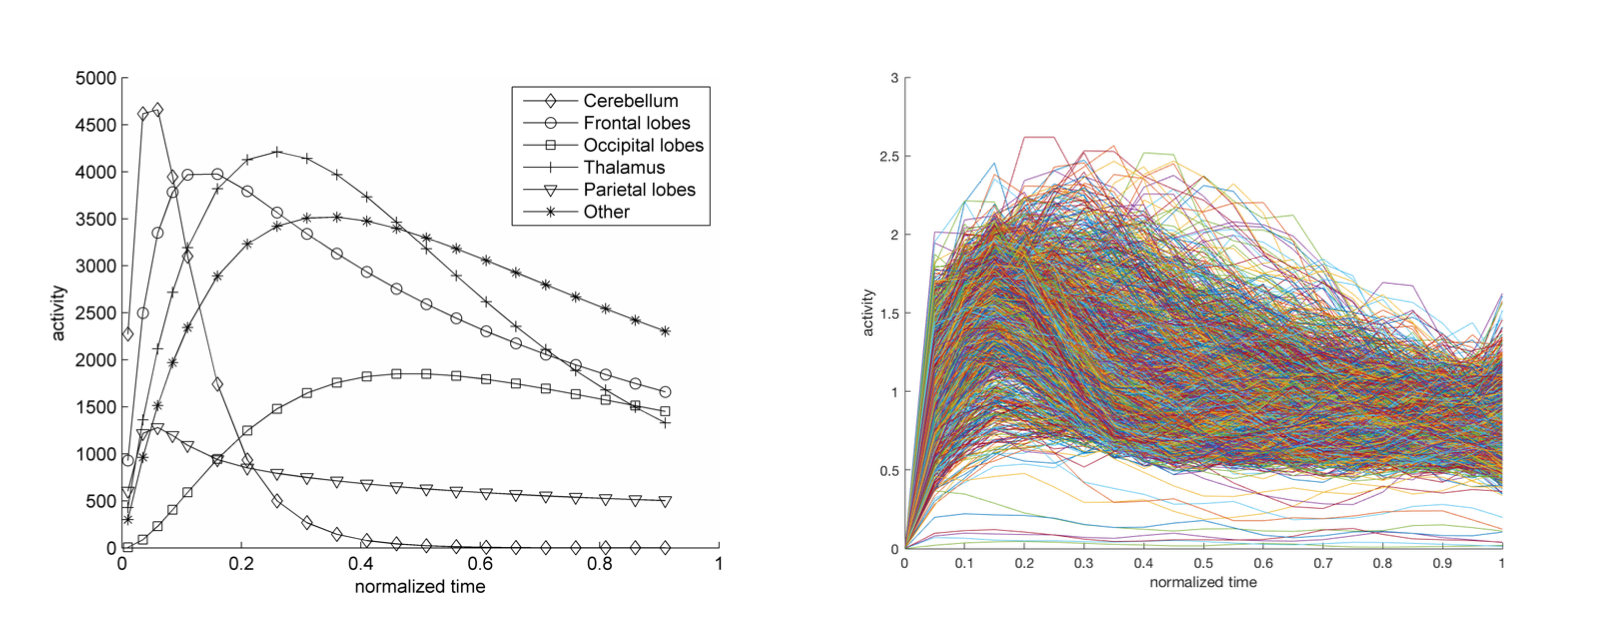


On dispose de données temporelles simulées (séquences de 20 instants) d'une coupe transverse et d'une coupe sagittale de taille $64\times 54$ (représentées sur la figure ci-dessus) que l'on souhaite segmenter sans prendre en compte l'information géométrique. On dispose aussi de la vérité terrain c'est-à-dire de la segmentation de ces coupes avant simulation. Ces matrices sont stockées respectivement dans les fichiers *DataTAC_S.mat* et *DataTAC_T.mat*.



(3456, 20)
Nombre de TAC de la coupe Sagittale : (3456, 20)
Nombre de TAC de la coupe Sagittale : (3456, 20)


Text(0.5, 1.0, 'TAC de Coupe Transverse')

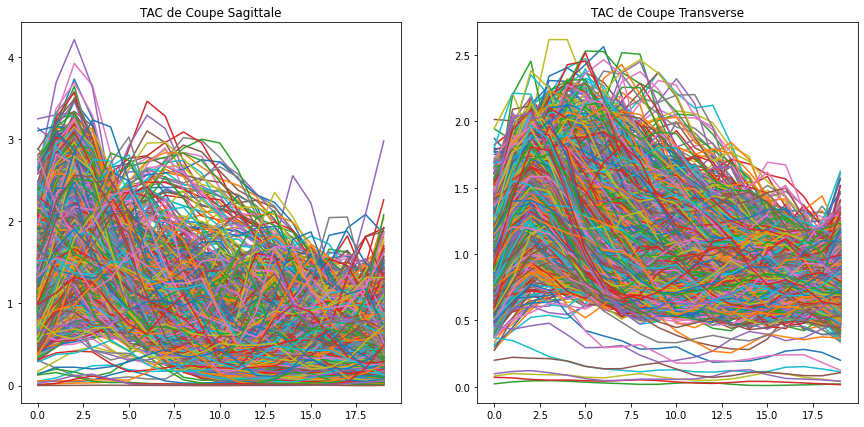

In [6]:
# Chargement de la coupe sagittale
matS = scipy.io.loadmat('DataTAC_S.mat')
data_S = pd.DataFrame(matS['DataTAC_S'])

print(data_S.shape)

print('Nombre de TAC de la coupe Sagittale :' ,data_S.shape)

# Chargement de la coupe transverse
matT = scipy.io.loadmat('DataTAC_T.mat')
data_T = pd.DataFrame(matT['DataTAC_T'])

print('Nombre de TAC de la coupe Sagittale :', data_T.shape)

# Affichage des TAC des deux coupes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
axs[0].plot(data_S.T)
axs[0].set_title('TAC de Coupe Sagittale')
axs[1].plot(data_T.T)
axs[1].set_title('TAC de Coupe Transverse')


3456    [0 0 0 ... 8 8 8]
[[0 0 0 ... 0 8 8]
 [0 0 0 ... 0 5 8]
 [0 0 0 ... 2 0 5]
 ...
 [0 2 0 ... 2 8 8]
 [0 0 0 ... 5 8 8]
 [2 0 0 ... 8 8 8]]


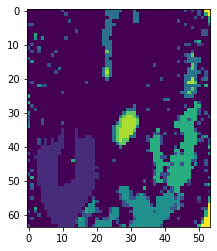

In [7]:
# Test de la classification spectrale sur image sagittale de taille (54,64) comprenant 9 classes
k = 9
nbCluster = 9
sigma = 0.30

cluster = classification_spectrale(data_S,k,sigma,nbCluster)

print(len(cluster) , "  ", cluster )

# Redimensionnement de la partition de la coupe saggitale en (54,64)
image_SC_S = np.reshape(cluster,((54,64))).T

print(image_SC_S)
plt.imshow(image_SC_S)

3456    [1 1 1 ... 2 2 2]
[[1 1 1 ... 1 2 2]
 [1 1 1 ... 1 4 2]
 [1 1 1 ... 1 1 4]
 ...
 [1 1 1 ... 1 2 2]
 [1 1 1 ... 4 2 2]
 [1 1 1 ... 2 2 2]]


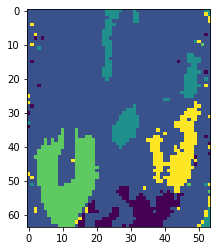

In [8]:
# Test de la classification spectrale sur image sagittale de taille (54,64) comprenant 5 classes
k = 10
sigma = 0.31
nbCluster = 5

cluster = classification_spectrale(data_S, k, sigma, nbCluster)

print(len(cluster) , "  ", cluster )

# Redimensionnement de la partition de la coupe saggitale en (54,64)
image_SC_S = np.reshape(cluster,((54,64))).T

print(image_SC_S)
plt.imshow(image_SC_S)

3456    [0 0 0 ... 0 0 6]
[[0 0 0 ... 6 6 6]
 [0 0 0 ... 6 6 6]
 [0 0 0 ... 0 6 6]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 6]]


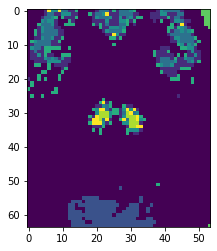

In [9]:
# Test de la classification spectrale sur image transversale de taille (54,64) comprenant 9 classes
k = 9
nbCluster = 9
sigma = 0.30

cluster = classification_spectrale(data_T,k,sigma,nbCluster)

print(len(cluster) , "  ", cluster )

# Redimensionnement de la partition de la coupe transversale en (54,64)
image_SC_T = np.reshape(cluster,((54,64))).T

print(image_SC_T)
plt.imshow(image_SC_T)

3456    [0 0 0 ... 0 0 4]
[[0 0 0 ... 4 4 4]
 [0 0 0 ... 4 4 4]
 [0 0 0 ... 0 4 4]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 4]]


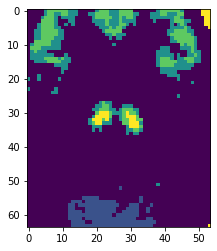

In [10]:
# Test de la classification spectrale sur image transversale de taille (54,64) comprenant 5 classes
k = 9
nbCluster = 5
sigma = 0.3

cluster = classification_spectrale(data_T,k,sigma,nbCluster)

print(len(cluster) , "  ", cluster )

# Redimensionnement de la partition de la coupe transversale en (54,64)
image_SC_T = np.reshape(cluster,((54,64))).T

print(image_SC_T)
plt.imshow(image_SC_T)

# Partie III : comparaison avec  kmeans (+ ACP)

- Réaliser une classification avec le kmeans de sklearn
- Tester aussi une réduction de dimension par ACP comme étape de prétraitement qui conserverait 95% de l'information

(250, 2)
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 1 3 1 3 1 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 0
 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


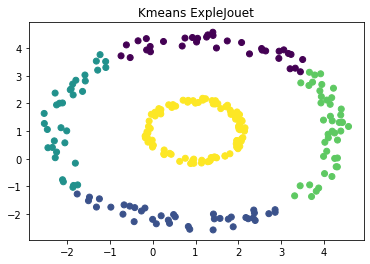

(3456, 20)
[[0 0 4 ... 0 1 1]
 [4 4 4 ... 4 1 1]
 [4 4 4 ... 0 4 1]
 ...
 [4 0 4 ... 1 1 1]
 [4 4 4 ... 1 1 1]
 [0 4 4 ... 1 1 1]]


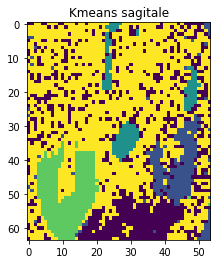

[[3 1 3 ... 4 4 4]
 [1 1 3 ... 3 4 4]
 [3 3 3 ... 3 4 4]
 ...
 [1 3 3 ... 3 3 1]
 [1 3 3 ... 1 3 3]
 [3 3 1 ... 1 3 3]]


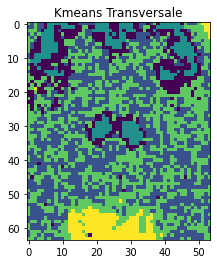

In [11]:
# Tester Kmeans avec l'exemple jouet et afficher le résultat 
matJouet = scipy.io.loadmat("ToyExample.mat")

ExpleJouet = pd.DataFrame(matJouet['Data'])
ExpleJouet=np.asarray(ExpleJouet)

print(ExpleJouet.shape)

# Visualisation du jeu de données 
#plt.plot(ExpleJouet[:,0],ExpleJouet[:,1],'.')

k = 5
kmeansExple = KMeans(n_clusters=k, random_state=0).fit(ExpleJouet)
print(kmeansExple.labels_)

#partage les lignes sur x et colonnes sur y
plt.scatter(ExpleJouet[:,0], ExpleJouet[:,1], c = kmeansExple.labels_)

plt.title('Kmeans ExpleJouet')
plt.show()

print(data_T.shape)

#sclicing error without iloc
# => iloc is the dataframe property that allows integer-location based indexing, and values removes the labels returning only the actual values.

kmeans_S = KMeans(n_clusters=k, random_state=0).fit(data_S)
cluster = kmeans_S.labels_
image_kmeans_S = np.reshape(cluster,((54,64))).T

print(image_kmeans_S)
plt.imshow(image_kmeans_S)

plt.title('Kmeans sagitale')
plt.show()

kmeans_T = KMeans(n_clusters=k, random_state=0).fit(data_T)
cluster = kmeans_T.labels_
image_kmeans_T = np.reshape(cluster,((54,64))).T

print(image_kmeans_T)
plt.imshow(image_kmeans_T)

plt.title('Kmeans Transversale')
plt.show()




[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 1 3 1 3 1 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 0
 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


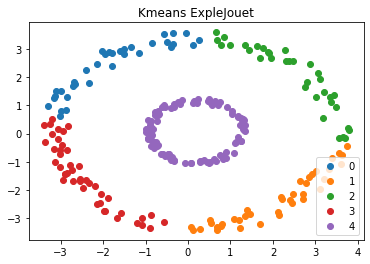

Variance_T =  1.0
Variance_S =  1.0


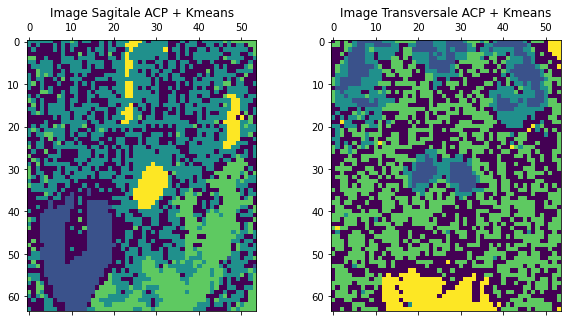

In [31]:
# Tester Kmeans avec l'exemple jouet et afficher le résultat 
matJouet = scipy.io.loadmat("ToyExample.mat")

ExpleJouet = pd.DataFrame(matJouet['Data'])
ExpleJouet=np.asarray(ExpleJouet)

# Visualisation du jeu de données 
#plt.plot(ExpleJouet[:,0],ExpleJouet[:,1],'.')

k = 5
pca_ExpleJouet = PCA(n_components=2)
df = pca_ExpleJouet.fit_transform(ExpleJouet)
#print(df.shape)

kmeansExple = KMeans(n_clusters=k, random_state=0)
label = kmeansExple.fit_predict(df)
print(label)

u_labels = np.unique(label)

for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)

plt.legend()
plt.title('Kmeans ExpleJouet')
plt.show()

# Classification sur les courbes TACS
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

k = 5
pca_data_S = PCA(n_components=2)
df = pca_data_S.fit_transform(data_S)
explained_variance_S = pca_data_S.explained_variance_ratio_
#print(df.shape)

kmeans_S = KMeans(n_clusters=k, random_state=0)
label = kmeans_S.fit_predict(df)

image_ACPkmeans_S = np.reshape(label,((54,64))).T

axs[0].set_title('Image Sagitale ACP + Kmeans')
axs[0].matshow(image_ACPkmeans_S)

k = 5
pca_data_T = PCA(n_components=2)
df = pca_data_T.fit_transform(data_T)
explained_variance_T = pca_data_T.explained_variance_ratio_
#print(df.shape)

kmeans_T = KMeans(n_clusters=k, random_state=0)
label = kmeans_T.fit_predict(df)

image_ACPkmeans_T = np.reshape(label,((54,64))).T

axs[1].set_title('Image Transversale ACP + Kmeans')
axs[1].matshow(image_ACPkmeans_T)

#somme des variances des deux composantes principales
variance_T = 0
for val in range(explained_variance_T.shape[0]):
    variance_T += val
    
variance_S = 0
for val in range(explained_variance_S.shape[0]):
    variance_S += val

print("Variance_T = ", float(variance_T))
print("Variance_S = ", float(variance_S))

#variances = 1 => on conserve 100% des données

# Partie IV : Comparaison avec vérité terrain


En utilisant la vérité terrain des coupes (repectivement les matrices *ImageROI_DataSagittale*, *Image_ROI_DataTransverse*, analyser vos résultats et améliorer les.


<img src="files/VeriteTerrain.png" width="600" height="300">


Text(0.5, 1.0, 'Partition kmeans + ACP')

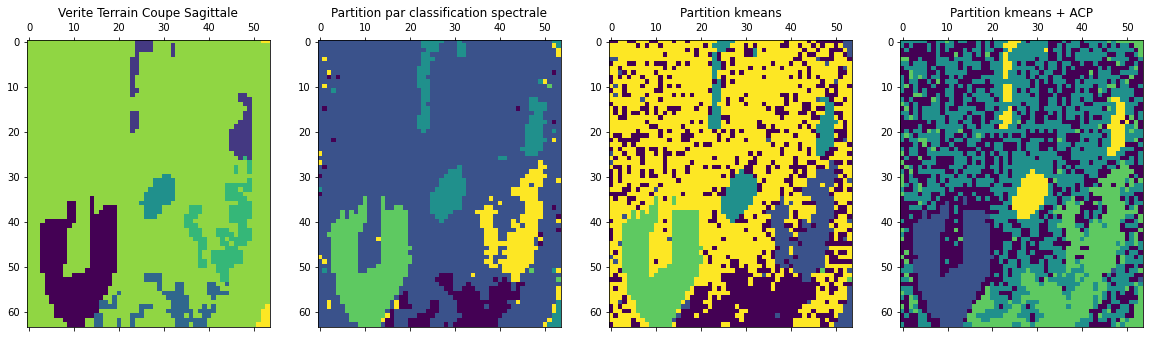

In [26]:
dataROISagit= scipy.io.loadmat('ImageROI_DataSagittale.mat') 
dataROI_S = pd.DataFrame(dataROISagit['Image_ROI_S'])


# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
axs[0].matshow(dataROI_S)
axs[0].set_title('Verite Terrain Coupe Sagittale')
axs[1].matshow(image_SC_S)
axs[1].set_title('Partition par classification spectrale')
axs[2].matshow(image_kmeans_S)
axs[2].set_title('Partition kmeans')
axs[3].matshow(image_ACPkmeans_S)
axs[3].set_title('Partition kmeans + ACP')


Text(0.5, 1.0, 'Partition kmeans + ACP')

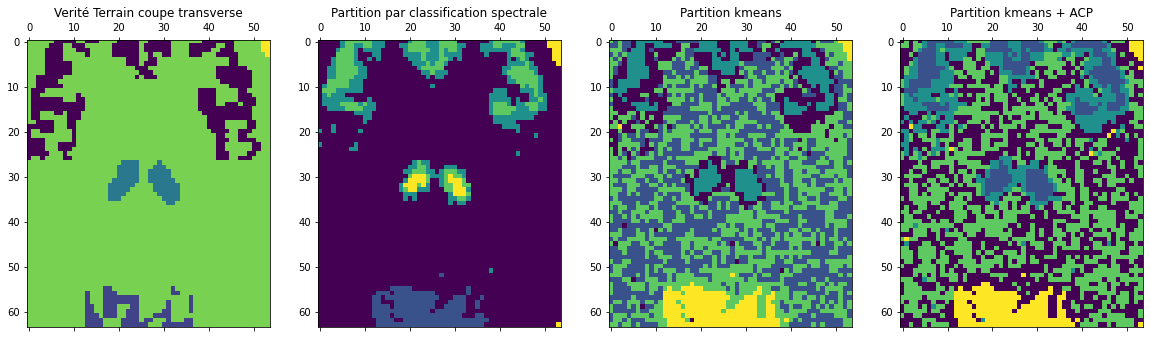

In [27]:
dataROITrans= scipy.io.loadmat('ImageROI_DataTransverse.mat') 
dataROI_T = pd.DataFrame(dataROITrans['Image_ROI_T'])


# résultat vérité terrain et clustering spectral
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))
axs[0].matshow(dataROI_T)
axs[0].set_title('Verité Terrain coupe transverse')
axs[1].matshow(image_SC_T)
axs[1].set_title('Partition par classification spectrale')
axs[2].matshow(image_kmeans_T) 
axs[2].set_title('Partition kmeans')
axs[3].matshow(image_ACPkmeans_T)
axs[3].set_title('Partition kmeans + ACP')

## Calcul de mesures de précision et rappel 

**Précision :** évalue l'exactitude des prédictions positives
$$Precision=\frac{TP}{TP+FP}$$
**Rappel :** évalue le taux d'observations positives ayant été correctement détectées par le classifieur
$$Rappel = \frac{TP}{TP+FN}$$

<img src="files/PrecisionRappel.png" width="600" height="1000">


**Indice de Fowlkes-Mallows index (FMI)** mesure la similarité entre deux partitionnements. C'est une moyenne géométrique entre la précision et le rappel :

$$FMI = \frac{TP}{\sqrt{TP + FP) * (TP + FN)}}$$

In [28]:
from sklearn.metrics.cluster import fowlkes_mallows_score


# Coupe Sagittale : Vectorisation de l'image de verité terrain
#VecdataROI_S=np.ravel(dataROI_S)

# Récupérer la valeur du fond (celle la plus présente dans l'image) dans Data
vec_dataROI_S = [int(v) for v in np.array(dataROI_S).flatten()]
irrelevant_data_S = np.argmax(np.bincount(vec_dataROI_S))

# Mesure d'évalution pour la coupe sagittale  pour la classification spectrale
#resultatSC=fowlkes_mallows_score(VecdataROI_S,PartitionSC_S)
#print('Resultat Sagittale - Classification Spectrale :',resultatSC)

TP_SC_S = 0
FP_SC_S = 0
TN_SC_S = 0
FN_SC_S = 0

# Récupérer la valeur du fond dans l'image spectrale
vec_SC_S = [int(v) for v in np.array(image_SC_S).flatten()]
irrelevant_SC_S = np.argmax(np.bincount(vec_SC_S))

#catégorisation en TP/FP/TN/FN
for i in range (len(vec_dataROI_S)):
	if vec_dataROI_S[i] == irrelevant_data_S and vec_SC_S[i] == irrelevant_SC_S:
		TN_SC_S+=1
	elif vec_dataROI_S[i] != irrelevant_data_S and vec_SC_S[i] != irrelevant_SC_S:
		TP_SC_S+=1
	elif vec_dataROI_S[i] == irrelevant_data_S and vec_SC_S[i] != irrelevant_SC_S:
		FP_SC_S+=1
	elif vec_dataROI_S[i] != irrelevant_data_S and vec_SC_S[i] == irrelevant_SC_S:
		FN_SC_S+=1

precision_SC_S = TP_SC_S / (TP_SC_S + FP_SC_S)
print("Précision CS sagitale : ", precision_SC_S)
rappel_SC_S = TP_SC_S / (TP_SC_S + FN_SC_S)
print("Rappel CS sagitale : ", rappel_SC_S)
FMI_SC_S = TP_SC_S / (((TP_SC_S + FP_SC_S)*(TP_SC_S + FN_SC_S))**0.5)
print("FMI CS sagitale : ", FMI_SC_S, "\n")

# Mesure d'évalution pour la coupe sagittale  pour le Kmeans 

TP_kmeans_S = 0
FP_kmeans_S = 0
TN_kmeans_S = 0
FN_kmeans_S = 0

# Récupérer la valeur du fond dans l'image spectrale
vec_kmeans_S = [int(v) for v in np.array(image_kmeans_S).flatten()]
irrelevant_Kmeans_S = np.argmax(np.bincount(vec_kmeans_S))

#catégorisation en TP/FP/TN/FN
for i in range (len(vec_dataROI_S)):
	if vec_dataROI_S[i] == irrelevant_data_S and vec_kmeans_S[i] == irrelevant_Kmeans_S:
		TN_kmeans_S+=1
	elif vec_dataROI_S[i] != irrelevant_data_S and vec_kmeans_S[i] != irrelevant_Kmeans_S:
		TP_kmeans_S+=1
	elif vec_dataROI_S[i] == irrelevant_data_S and vec_kmeans_S[i] != irrelevant_Kmeans_S:
		FP_kmeans_S+=1
	elif vec_dataROI_S[i] != irrelevant_data_S and vec_kmeans_S[i] == irrelevant_Kmeans_S:
		FN_kmeans_S+=1

precision_Kmeans_S = TP_kmeans_S / (TP_kmeans_S + FP_kmeans_S)
print("Précision Kmeans sagitale : ", precision_Kmeans_S)
rappel_Kmeans_S = TP_kmeans_S / (TP_kmeans_S + FN_kmeans_S)
print("Rappel Kmeans sagitale : ", rappel_Kmeans_S)
FMI_Kmeans_S = TP_kmeans_S / (((TP_kmeans_S + FP_kmeans_S)*(TP_kmeans_S + FN_kmeans_S))**0.5)
print("FMI Kmeans sagitale : ", FMI_Kmeans_S, "\n")

# Mesure d'évalution pour la coupe sagittale  pour le Kmeans + ACP

TP_ACPkmeans_S = 0
FP_ACPkmeans_S = 0
TN_ACPkmeans_S = 0
FN_ACPkmeans_S = 0

# Récupérer la valeur du fond dans l'image spectrale
vec_ACPkmeans_S = [int(v) for v in np.array(image_ACPkmeans_S).flatten()]
irrelevant_ACPKmeans_S = np.argmax(np.bincount(vec_ACPkmeans_S))

#catégorisation en TP/FP/TN/FN
for i in range (len(vec_dataROI_S)):
	if vec_dataROI_S[i] == irrelevant_data_S and vec_ACPkmeans_S[i] == irrelevant_ACPKmeans_S:
		TN_ACPkmeans_S+=1
	elif vec_dataROI_S[i] != irrelevant_data_S and vec_ACPkmeans_S[i] != irrelevant_ACPKmeans_S:
		TP_ACPkmeans_S+=1
	elif vec_dataROI_S[i] == irrelevant_data_S and vec_ACPkmeans_S[i] != irrelevant_ACPKmeans_S:
		FP_ACPkmeans_S+=1
	elif vec_dataROI_S[i] != irrelevant_data_S and vec_ACPkmeans_S[i] == irrelevant_ACPKmeans_S:
		FN_ACPkmeans_S+=1

precision_ACPKmeans_S = TP_ACPkmeans_S / (TP_ACPkmeans_S + FP_ACPkmeans_S)
print("Précision Kmeans + ACP sagitale : ", precision_ACPKmeans_S)
rappel_ACPKmeans_S = TP_ACPkmeans_S / (TP_kmeans_S + FN_ACPkmeans_S)
print("Rappel Kmeans + ACP sagitale : ", rappel_ACPKmeans_S)
FMI_ACPKmeans_S = TP_ACPkmeans_S / (((TP_kmeans_S + FP_ACPkmeans_S)*(TP_ACPkmeans_S + FN_ACPkmeans_S))**0.5)
print("FMI Kmeans + ACP sagitale : ", FMI_ACPKmeans_S, "\n")



Précision CS sagitale :  0.7317620650953984
Rappel CS sagitale :  0.9354375896700143
FMI CS sagitale :  0.8273558740861103 

Précision Kmeans sagitale :  0.4316129032258065
Rappel Kmeans sagitale :  0.9598278335724534
FMI Kmeans sagitale :  0.6436412648713123 

Précision Kmeans + ACP sagitale :  0.3201368523949169
Rappel Kmeans + ACP sagitale :  0.9212376933895922
FMI Kmeans + ACP sagitale :  0.5466272786724091 



In [29]:


# Coupe Sagittale : Vectorisation de l'image de verité terrain
#VecdataROI_S=np.ravel(dataROI_S)

# Récupérer la valeur du fond (celle la plus présente dans l'image) dans Data
vec_dataROI_T = [int(v) for v in np.array(dataROI_T).flatten()]
irrelevant_data_T = np.argmax(np.bincount(vec_dataROI_T))

# Mesure d'évalution pour la coupe sagittale  pour la classification spectrale
#resultatSC=fowlkes_mallows_score(VecdataROI_S,PartitionSC_S)
#print('Resultat Sagittale - Classification Spectrale :',resultatSC)

TP_SC_T = 0
FP_SC_T = 0
TN_SC_T = 0
FN_SC_T = 0

# Récupérer la valeur du fond dans l'image spectrale
vec_SC_T = [int(v) for v in np.array(image_SC_T).flatten()]
irrelevant_SC_T = np.argmax(np.bincount(vec_SC_T))

#catégorisation en TP/FP/TN/FN
for i in range (len(vec_dataROI_T)):
	if vec_dataROI_T[i] == irrelevant_data_T and vec_SC_T[i] == irrelevant_SC_T:
		TN_SC_T+=1
	elif vec_dataROI_T[i] != irrelevant_data_T and vec_SC_T[i] != irrelevant_SC_T:
		TP_SC_T+=1
	elif vec_dataROI_T[i] == irrelevant_data_T and vec_SC_T[i] != irrelevant_SC_T:
		FP_SC_T+=1
	elif vec_dataROI_T[i] != irrelevant_data_T and vec_SC_T[i] == irrelevant_SC_T:
		FN_SC_T+=1

precision_SC_T = TP_SC_T / (TP_SC_T + FP_SC_T)
print("Précision CS transversale : ", precision_SC_T)
rappel_SC_T = TP_SC_T / (TP_SC_T + FN_SC_T)
print("Rappel CS transversale : ", rappel_SC_T)
FMI_SC_T = TP_SC_T / (((TP_SC_T + FP_SC_T)*(TP_SC_T + FN_SC_T))**0.5)
print("FMI CS transversale : ", FMI_SC_T, "\n")

# Mesure d'évalution pour la coupe sagittale  pour le Kmeans 

TP_kmeans_T = 0
FP_kmeans_T = 0
TN_kmeans_T = 0
FN_kmeans_T = 0

# Récupérer la valeur du fond dans l'image spectrale
vec_kmeans_T = [int(v) for v in np.array(image_kmeans_T).flatten()]
irrelevant_Kmeans_T = np.argmax(np.bincount(vec_kmeans_T))

#catégorisation en TP/FP/TN/FN
for i in range (len(vec_dataROI_T)):
	if vec_dataROI_T[i] == irrelevant_data_T and vec_kmeans_T[i] == irrelevant_Kmeans_T:
		TN_kmeans_T+=1
	elif vec_dataROI_T[i] != irrelevant_data_T and vec_kmeans_T[i] != irrelevant_Kmeans_T:
		TP_kmeans_T+=1
	elif vec_dataROI_T[i] == irrelevant_data_T and vec_kmeans_T[i] != irrelevant_Kmeans_T:
		FP_kmeans_T+=1
	elif vec_dataROI_T[i] != irrelevant_data_T and vec_kmeans_T[i] == irrelevant_Kmeans_T:
		FN_kmeans_T+=1

precision_Kmeans_T = TP_kmeans_T / (TP_kmeans_T + FP_kmeans_T)
print("Précision Kmeans transversale : ", precision_Kmeans_T)
rappel_Kmeans_T = TP_kmeans_T / (TP_kmeans_T + FN_kmeans_T)
print("Rappel Kmeans transversale : ", rappel_Kmeans_T)
FMI_Kmeans_T = TP_kmeans_T / (((TP_kmeans_T + FP_kmeans_T)*(TP_kmeans_T + FN_kmeans_T))**0.5)
print("FMI Kmeans transversale : ", FMI_Kmeans_T, "\n")

# Mesure d'évalution pour la coupe sagittale  pour le Kmeans + ACP

TP_ACPkmeans_T = 0
FP_ACPkmeans_T = 0
TN_ACPkmeans_T = 0
FN_ACPkmeans_T = 0

# Récupérer la valeur du fond dans l'image spectrale
vec_ACPkmeans_T = [int(v) for v in np.array(image_ACPkmeans_T).flatten()]
irrelevant_ACPKmeans_T = np.argmax(np.bincount(vec_ACPkmeans_T))

#catégorisation en TP/FP/TN/FN
for i in range (len(vec_dataROI_S)):
	if vec_dataROI_T[i] == irrelevant_data_T and vec_ACPkmeans_T[i] == irrelevant_ACPKmeans_T:
		TN_ACPkmeans_T+=1
	elif vec_dataROI_T[i] != irrelevant_data_T and vec_ACPkmeans_T[i] != irrelevant_ACPKmeans_T:
		TP_ACPkmeans_T+=1
	elif vec_dataROI_T[i] == irrelevant_data_T and vec_ACPkmeans_T[i] != irrelevant_ACPKmeans_T:
		FP_ACPkmeans_T+=1
	elif vec_dataROI_T[i] != irrelevant_data_T and vec_ACPkmeans_T[i] == irrelevant_ACPKmeans_T:
		FN_ACPkmeans_T+=1

precision_ACPKmeans_T = TP_ACPkmeans_T / (TP_ACPkmeans_T + FP_ACPkmeans_T)
print("Précision Kmeans + ACP transversale : ", precision_ACPKmeans_T)
rappel_ACPKmeans_T = TP_ACPkmeans_T / (TP_kmeans_T + FN_ACPkmeans_T)
print("Rappel Kmeans + ACP transversale : ", rappel_ACPKmeans_T)
FMI_ACPKmeans_T = TP_ACPkmeans_T / (((TP_kmeans_T + FP_ACPkmeans_T)*(TP_ACPkmeans_T + FN_ACPkmeans_T))**0.5)
print("FMI Kmeans + ACP transversale : ", FMI_ACPKmeans_T, "\n")


Précision CS transversale :  0.7212389380530974
Rappel CS transversale :  0.815
FMI CS transversale :  0.7666875077326318 

Précision Kmeans transversale :  0.25731822474032107
Rappel Kmeans transversale :  0.9083333333333333
FMI Kmeans transversale :  0.4834570516662174 

Précision Kmeans + ACP transversale :  0.25749063670411987
Rappel Kmeans + ACP transversale :  0.9243697478991597
FMI Kmeans + ACP transversale :  0.4864019859262808 



# Partie V : votre analyse

A partir des méthodes que vous avez implémentées, sur le notebook 
- Réaliser une analyse sur les résultats des méthodes de classification non supervisée : classification spectrale, kmeans et ACP+kmeans
- Tester pour différentes valeurs de paramètres $\sigma$ et de classes 

Rédiger sur un cartouche l'analyse effectuée et vos conclusions.

Le notebook sera à rendre sur moodle. 

## Votre analyse 


Rédiger votre analyse et vos conclusions.





